# Imports

In [1]:
import sys
sys.path.insert(1, '../')
from genesis import *

C:\Users\vin_s\AppData\Local\Programs\Python\Python39\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


In [2]:
universe = G10_FX
# universe = ASIA_FX
universe = ["USDEUR", "USDGBP", "USDAUD", "USDJPY", "USDCAD", "USDSEK", "USDCHF"]
total_returns = total_returns_usd[universe]
spot_returns = spot_returns_usd[universe]
carry_returns = carry_returns_usd[universe]

# Settings

In [208]:
settings = Settings(start_date = "2000-01-01", end_date = "2016-12-31", notional = 100, implementation_lag = 1,
             asset_scaling_method="simple", asset_scaling_target=None, asset_scaling_width=130, rebalance_period = "friday",
             sector_scaling_method="simple", sector_scaling_target=0.1, sector_scaling_width=130,
             portfolio_scaling_method="simple", portfolio_scaling_target=0.1, portfolio_scaling_width=260)

# Other Data

In [9]:
us_rates = read_prices("../../Dymon/Code Data/us_govs.csv")
us_rates.columns = [x[0] for x in us_rates.columns]
us_rates = us_rates.pipe(fill_date).pipe(omit_trailing_na).pipe(fill_date)

In [10]:
fs_data = three_month_fp_ori.copy()
fs_data.columns = fwd_scale.keys()
for i in fs_data.columns:
  fs_data.loc[:,i] = fwd_scale[i]

In [11]:
new_three_month_fp = three_month_fp_ori.copy()
new_three_month_fp.columns = fs_data.columns

In [25]:
three_month_implied = (new_three_month_fp/fs_data/spot_price_ori)[["EURUSD", "GBPUSD", "AUDUSD", "USDJPY", "USDCAD", "USDSEK", "USDCHF"]]
three_month_implied = (standardize_series(three_month_implied, "returns") * 100).pipe(fill_date).pipe(omit_trailing_na)
three_month_implied = three_month_implied.pipe(omit_trailing_na)
# three_month_implied = three_month_implied.apply(lambda col : col + us_rates["USGG3M Index"]).pipe(omit_trailing_na)

In [26]:
two_year_rates = two_year_rates_ori.copy()
two_year_rates.columns = fs_data.columns
two_year_rates = two_year_rates[["EURUSD", "GBPUSD", "AUDUSD", "USDJPY", "USDCAD", "USDSEK", "USDCHF"]]
two_year_rates = standardize_series(two_year_rates, "returns")#.pipe(fill_date).pipe(omit_trailing_na)

ten_year_rates = ten_year_rates_ori.copy()
ten_year_rates.columns = fs_data.columns
ten_year_rates = ten_year_rates[["EURUSD", "GBPUSD", "AUDUSD", "USDJPY", "USDCAD", "USDSEK", "USDCHF"]]
ten_year_rates = standardize_series(ten_year_rates, "returns")#.pipe(fill_date).pipe(omit_trailing_na)

In [14]:
g7_level = (three_month_implied + ten_year_rates)/2
g7_slope = ten_year_rates - three_month_implied
g7_curve = 2*two_year_rates - (three_month_implied + ten_year_rates)

us_level = (us_rates["USGG3M Index"] + us_rates["USGG10Y Index"])/2
us_slope = us_rates["USGG10Y Index"] - us_rates["USGG3M Index"]
us_curve = 2*us_rates["USGG2Y Index"] - (us_rates["USGG3M Index"] + us_rates["USGG10Y Index"])

In [15]:
# aa = (ten_year_rates.ffill().pipe(demean, window=252) + three_month_implied.ffill().pipe(demean, window=252)) / 2
# bb = (us_rates["USGG3M Index"].ffill().pipe(demean, window=252) + us_rates["USGG10Y Index"].ffill().pipe(demean, window=252))/2
# cc = aa.apply(lambda x: x - bb) * -1

# aa = (ten_year_rates.ffill().pipe(demean, window=252) - three_month_implied.ffill().pipe(demean, window=252)) / 2
# bb = us_rates["USGG10Y Index"].ffill().pipe(demean, window=252) - us_rates["USGG3M Index"].ffill().pipe(demean, window=252)
# cc = aa.apply(lambda x: x - bb)

# aa = 2*two_year_rates.ffill().pipe(demean, window=252) - (ten_year_rates.ffill().pipe(demean, window=252) + three_month_implied.ffill().pipe(demean, window=252))
# bb = 2*us_rates["USGG2Y Index"].ffill().pipe(demean, window=252) - (us_rates["USGG10Y Index"].ffill().pipe(demean, window=252) + us_rates["USGG3M Index"].ffill().pipe(demean, window=252))
# cc = aa.apply(lambda x: x - bb) * -1

In [16]:
level_signal = g7_level.pct_change(252).apply(lambda x: x - us_level.pct_change(252)).pipe(omit_trailing_na)
slope_signal = g7_slope.pct_change(252).apply(lambda x: x - us_slope.pct_change(252)).pipe(omit_trailing_na)
curve_signal = g7_curve.pct_change(252).apply(lambda x: x - us_curve.pct_change(252)).pipe(omit_trailing_na)

# Signal

In [17]:
sig =  g7_curve.ffill().apply(lambda x: x - us_level.ffill()).pipe(omit_trailing_na).pipe(zscore, 252)

In [58]:
sig = level_signal.ffill().pipe(omit_trailing_na).pipe(zscore, 252)
sig = sig.pipe(demean_xs)
sig = sig.apply(off_xs, axis=1)

In [60]:
# slope_signal["USDEUR"].pipe(zscore, 252).pipe(cap_helper, 5).plot()

In [19]:
sig = level_signal.ffill().pipe(zscore, 252).pipe(cap_helper, 5) * -1
sig = curve_signal.ffill().pipe(zscore, 252).pipe(cap_helper, 4) * -1
# sig = slope_signal.ffill().pipe(zscore, 252).pipe(cap_helper, 4) * -1
sig = sig.pipe(demean_xs)

In [239]:
sig = (ten_year_rates + two_year_rates)/2
sig = sig.apply(lambda x: x - (us_rates["USGG10Y Index"] + us_rates["USGG2Y Index"])/2)
sig = sig.pipe(omit_trailing_na).ffill()#.pipe(zscore, typ="median", window=252)
sig = sig.pipe(demean_xs)
# sig = (ten_year_rates.apply(lambda x: x - us_rates["USGG10Y Index"]) + three_month_implied)/2
# sig = sig.pipe(omit_trailing_na).ffill()#.pipe(zscore, typ="median", window=252)
# sig = sig.pipe(demean_xs)
# sig = sig.apply(off_xs, axis=1).pipe(rolling_mean, 5)

In [240]:
b = Backtest(signal = sig, asset_returns = total_returns, 
             tcost = abs(total_returns*0), 
             settings = settings)
b.run()

Re-arranging asset columns
Portfolio scaling ...
    Grouping by [ALL]


In [241]:
bt_obj = b

In [242]:
get_summary(bt_obj)

Returns   : 0.02693519348371154
Vol       : 0.09934106709116411
SR        : 0.2711385560112157
Max DD    : -25.47
Hit rate  : 0.515
W | N | L : 0.51 | 0.0 | 0.49
W/L Ratio : 1.06


In [243]:
get_returns_stats(bt_obj.asset_rtn, b.wts)

,USDEUR,USDGBP,USDAUD,USDJPY,USDCAD,USDSEK,USDCHF
annualized_return,2.087498,1.311832,3.396474,0.398485,-0.877234,-2.41813,-1.444695
sharpe,0.540708,0.283509,0.327859,0.183265,-0.153573,-0.356943,-0.422436
dollar_sharpe,0.477261,0.221381,0.191348,0.176205,-0.215873,-0.470747,-0.455743
trade_sharpe,0.540708,0.283509,0.327859,0.183265,-0.153573,-0.356943,-0.422436
long_sharpe,0.427352,NaN,NaN,0.191943,-0.160845,-0.373984,-0.455563
short_sharpe,0.586082,0.296936,0.343389,NaN,NaN,-3.880631,-0.426111
sortino,0.367269,0.194417,0.217221,0.118463,-0.112831,-0.252385,-0.265357
max_drawdown,-12.246019,-21.03937,-43.14425,-10.05746,-48.717085,-57.019855,-29.713234
max_drawdown_start,2008-07-11,2007-11-08,2013-04-11,2007-06-22,2002-01-18,2001-07-05,2001-07-05
max_drawdown_end,2010-06-07,2016-12-28,2015-09-04,2011-10-28,2007-11-06,2008-04-22,2011-08-09


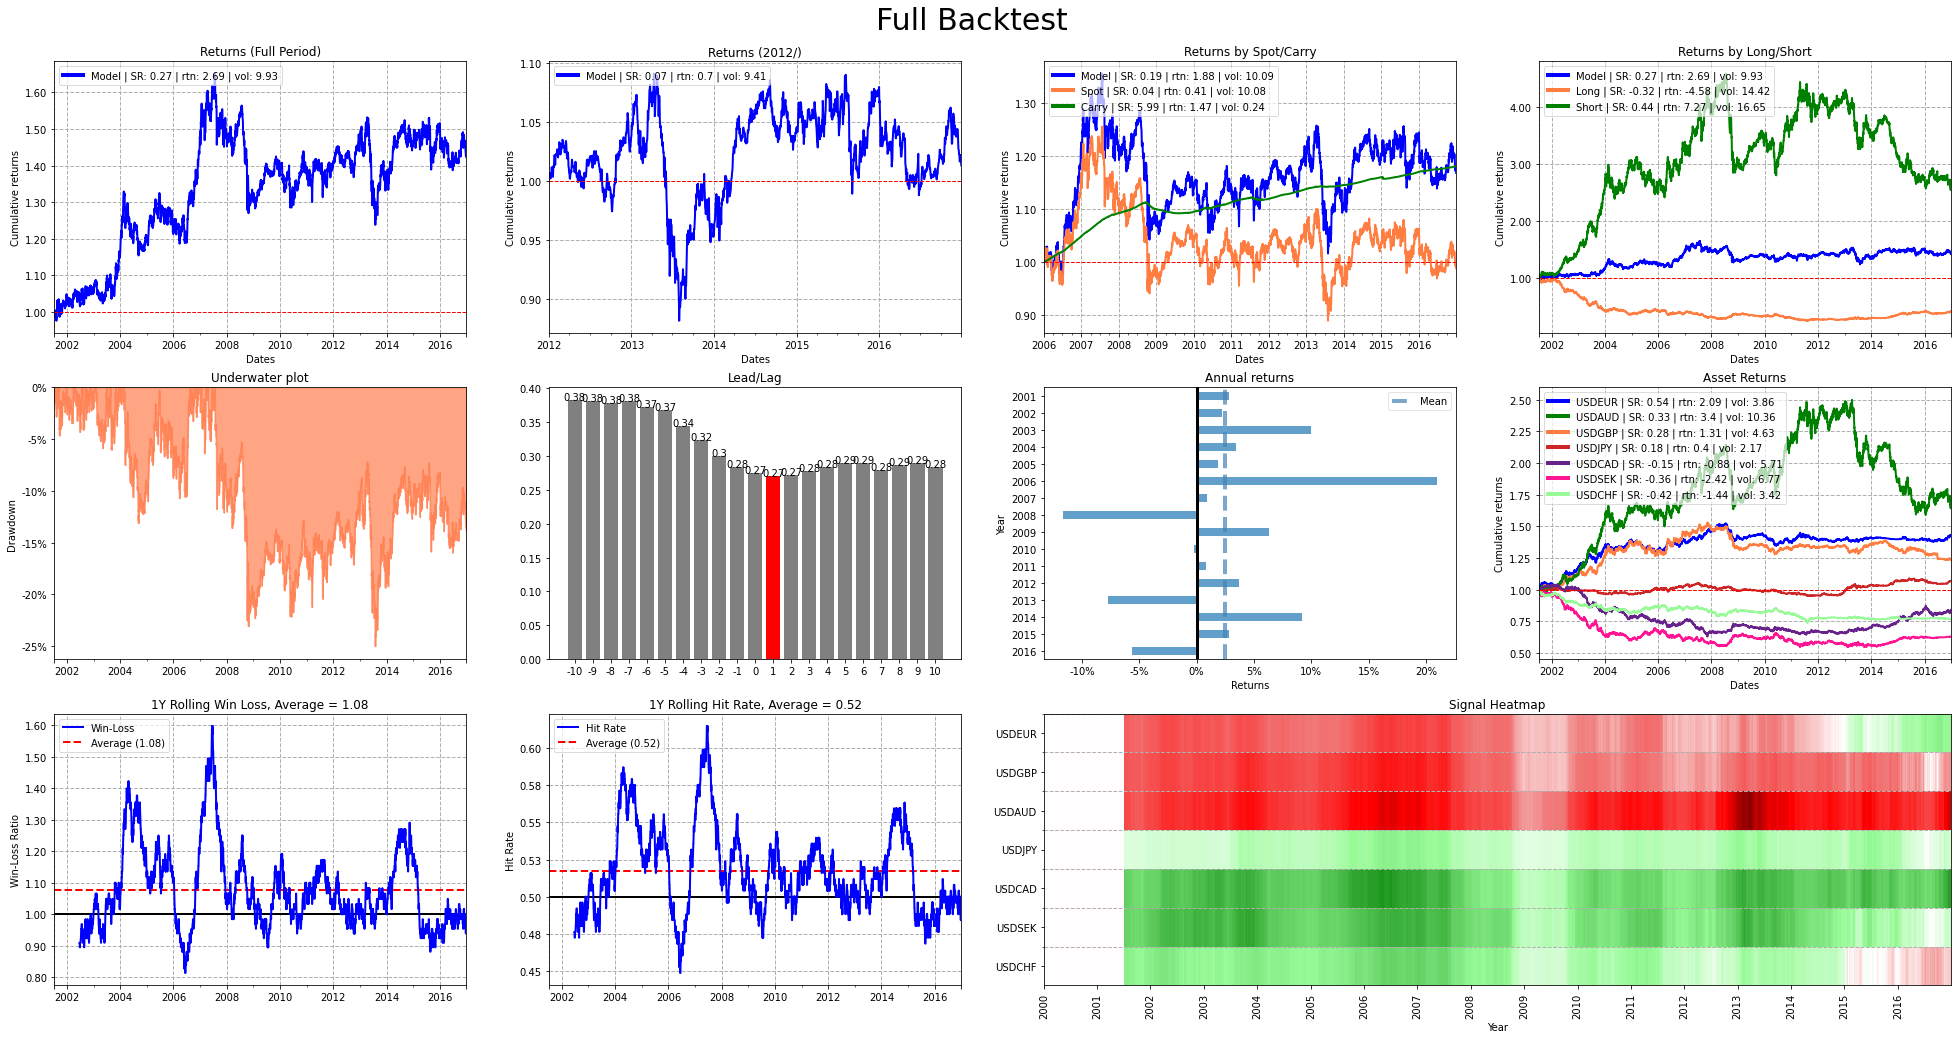

In [244]:
plot_bt(bt_obj)

In [ ]:
# ful = pd.read_csv("../davin_govies_full.csv")
# new_ful = ful.set_index(["Dates"])
# new_ful['GVTW1YR Index'] = pd.Series(np.nan)
# new_ful.index = pd.to_datetime(new_ful.index)
# new_ful = new_ful.astype(float)
# pd.concat([new_ful[["GNOR2YR Index"]], new_twoyear[["USDNOK"]]], axis=1).pipe(fill_date)
# msmx(pd.concat([new_ful[["GNOR2YR Index"]], new_twoyear[["USDNOK"]]], axis=1))